# Test PDPbox with Regression problem
## Kaggle Rossmann store with RandomForest regressor
This demo is based on **Rossmann Store Sales**  
https://www.kaggle.com/c/otto-group-product-classification-challenge

In [1]:
import pandas as pd
import numpy as np

%matplotlib inline

### read dataset

In [2]:
ross = pd.read_csv('rossmann_train.csv')
store = pd.read_csv('rossmann_store.csv')

C:\Users\jiangchun.li.ext.AXA-DIL\AppData\Local\Continuum\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### simple feature engineering

In [3]:
ross = ross[ross['Open'] != 0]
ross = ross.merge(store, on='Store', how='left')

In [4]:
ross['Date'] = pd.to_datetime(ross['Date'])
ross['year'] = ross.Date.apply(lambda x : x.year)
ross['month'] = ross.Date.apply(lambda x : x.month)
ross['weekofyear'] = ross.Date.apply(lambda x: x.weekofyear)
ross.drop(['Date'], axis=1, inplace=True)

In [5]:
ross = pd.get_dummies(ross, columns=['StateHoliday', 'StoreType', 'Assortment'])

In [6]:
ross_features = ['DayOfWeek', 'SchoolHoliday', 'month', 'weekofyear', 'StateHoliday_a', 'StateHoliday_b',
                 'StateHoliday_c', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 
                 'Assortment_a', 'Assortment_b','Assortment_c']

## RandomForestRegressor with PDPbox
### build model

In [7]:
from sklearn.ensemble import RandomForestRegressor

In [8]:
rf = RandomForestRegressor(n_estimators = 50, n_jobs=4)
%time rf.fit(ross[ross_features], ross['Sales'])

Wall time: 34.2 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## start testing PDPbox

In [9]:
import sys
sys.path.insert(0, '../../')
from pdpbox import pdp

## numeric feature: weekofyear

In [20]:
%time pdp_weekofyear = pdp.pdp_isolate(rf, ross[ross_features], 'weekofyear')

Wall time: 23.9 s


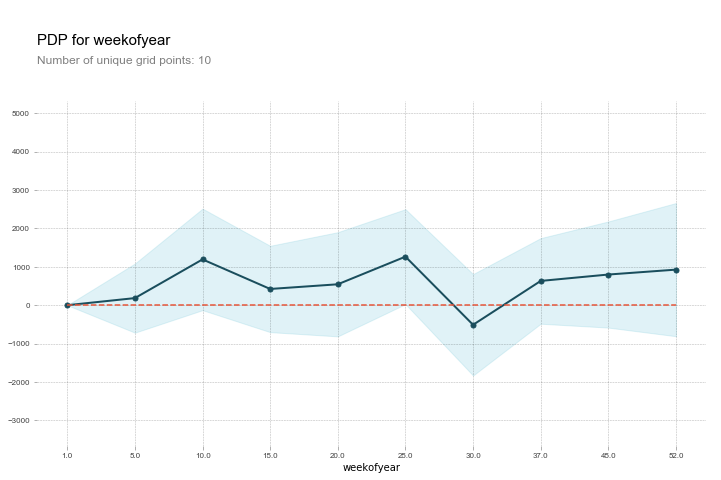

In [21]:
pdp.pdp_plot(pdp_weekofyear, 'weekofyear', figsize=(12, 8), x_quantile=True)

In [22]:
def weekofyear_ross_trans(df):
    df['month'] = df['weekofyear'].apply(lambda x : int(x / 4.33) + 1)
    df.loc[df['month'] > 12, 'month'] = 12 
    return df

In [1]:
52. / 12

4.333333333333333

In [23]:
%%time 
pdp_weekofyear2 = pdp.pdp_isolate(rf, ross[ross_features], 'weekofyear', data_transformer=weekofyear_ross_trans)

Wall time: 31.9 s


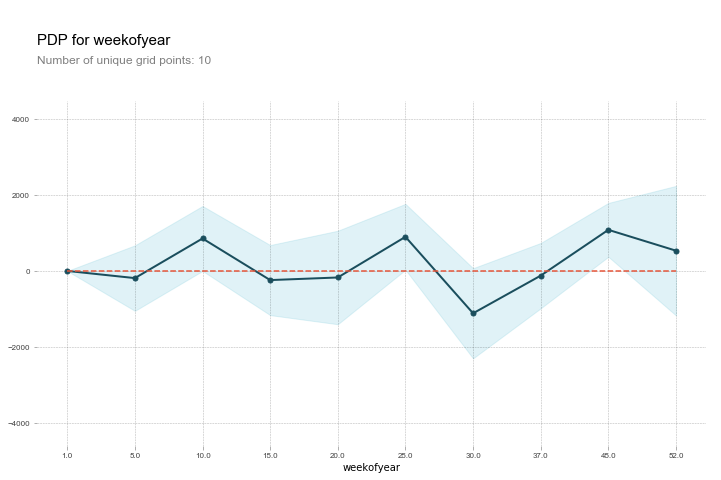

In [24]:
pdp.pdp_plot(pdp_weekofyear2, 'weekofyear', figsize=(12, 8), x_quantile=True)

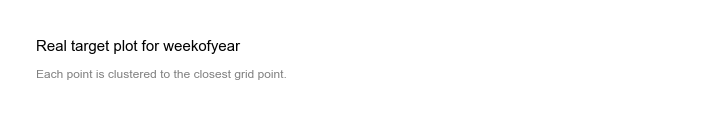

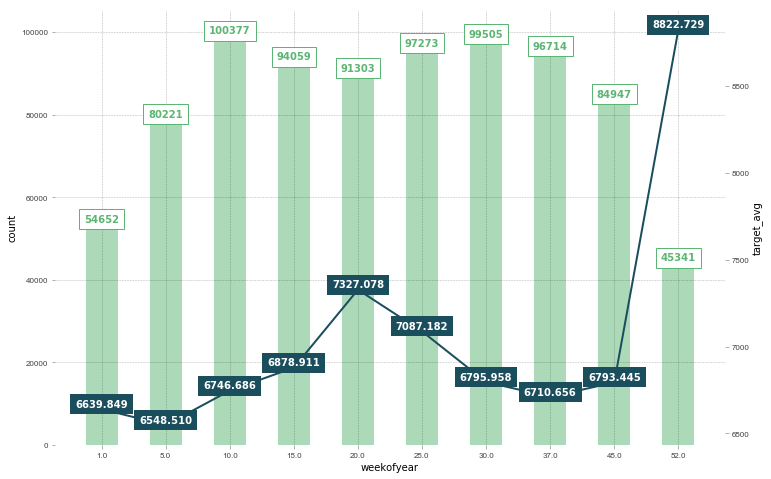

In [25]:
info_plots.target_plot(ross, 'weekofyear', 'weekofyear', 'Sales', figsize=(12, 8))

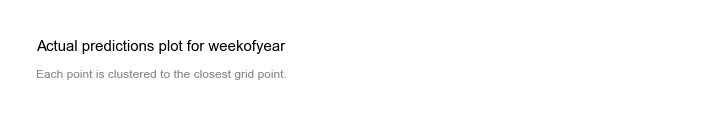

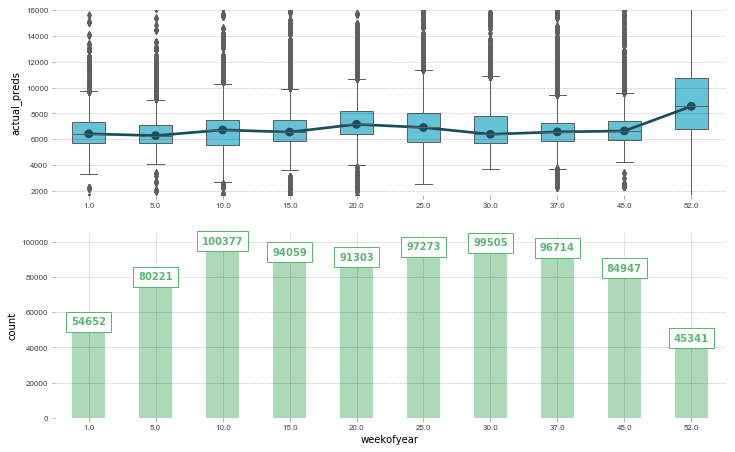

In [26]:
info_plots.actual_plot(pdp_weekofyear, 'weekofyear', figsize=(12, 8))